<a href="https://colab.research.google.com/github/nitingarg2015/EVA8/blob/master/Assignment%205/Assignment_5_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [73]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Load model.py and import Net class, generaty summary using torchsummary

In [92]:
#import model.py - contains model class which accepts type normalization method as input parameter

from model import Net

#instantiate Net class and check model summary

batch_model = Net('batch').to(device)
layer_model = Net('layer').to(device)
group_model = Net('group', num_groups = 2).to(device)

summary(batch_model, input_size=(1, 28, 28))
summary(layer_model, input_size=(1, 28, 28))
summary(group_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              80
       BatchNorm2d-2            [-1, 8, 28, 28]              16
           Dropout-3            [-1, 8, 28, 28]               0
            Conv2d-4           [-1, 16, 28, 28]           1,168
       BatchNorm2d-5           [-1, 16, 28, 28]              32
           Dropout-6           [-1, 16, 28, 28]               0
            Conv2d-7           [-1, 20, 28, 28]           2,900
       BatchNorm2d-8           [-1, 20, 28, 28]              40
           Dropout-9           [-1, 20, 28, 28]               0
           Conv2d-10            [-1, 8, 28, 28]             168
        MaxPool2d-11            [-1, 8, 14, 14]               0
          Dropout-12            [-1, 8, 14, 14]               0
           Conv2d-13            [-1, 8, 14, 14]             584
      BatchNorm2d-14            [-1, 8,

## Use dataloader to create training and test datasets, define batch size

In [75]:
# use dataloader to create training and test datasets with define batch size

torch.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomRotation((-5,5)),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


## Define functions for training the model for a given epoch and generating test outputs 

In [76]:
from tqdm import tqdm

''' 
train function taken inputs as pre defined model, device, train_loader (dataloader), pre defined optimizer,
and optional lambda_l1 for L1 regularization.
It returns the following: training loss, training accuracy for that epoch
'''
def train(model, device, train_loader, optimizer, lambda_l1=0):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
      # get samples
      data, target = data.to(device), target.to(device)

      # Init
      optimizer.zero_grad()
      # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
      # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

      # Predict
      y_pred = model(data)

      # Calculate loss
      loss = F.nll_loss(y_pred, target)

      #Add L1 Regularization if lambda_l1 > 0
      l1 = 0
      if lambda_l1 > 0:       
          for p in model.parameters():
            l1 = l1 + p.abs().sum()
      
      #update loss with L1 regularization
      loss = loss + lambda_l1 * l1

      # Backpropagation
      loss.backward()
      optimizer.step()

      # Update pbar-tqdm
      
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)

      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      acc = 100*correct/processed
  
  #return training loss and training accuracy for that epoch
  return loss, acc

''' 
test function taken inputs as pre defined model, device, test_loader (dataloader)
It returns the following: test loss, test accuracy for that epoch
'''

def test(model, device, test_loader):
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    acc = 100. * correct / len(test_loader.dataset)

    #return test loss and test accuracy
    return loss, acc

## train_model function to initate training for required number of epochs

In [79]:
# Set for training on GPU
#define optimizer
#set the loop for training in epochs
from model import Net

from torch.optim.lr_scheduler import StepLR # Import your choice of scheduler here

'''
train_model inputs - model_type - batch, layer, or group normalization, lambda_l1 if required for L1 Regularization, and
num_groups parameter for group normalization

Generated output: 
1. model - for generating test outputs
2. train_losses, train_acc_all, test_losses, test_acc_all - For further analysis and generating plots
'''

def train_model(model_type, device, num_epochs, lambda_l1 = 0, num_groups = 2):

    train_losses= []
    test_losses = []
    train_acc_all = []
    test_acc_all = []

    model = Net(model_type, num_groups = num_groups).to(device)
    
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
    scheduler = StepLR(optimizer, step_size=4, gamma=0.4)
    
    for epoch in range(1, num_epochs+1):

      print("EPOCH:", epoch, "Learning Rate: ", optimizer.param_groups[0]["lr"])
      train_loss, train_acc = train(model, device, train_loader, optimizer, lambda_l1)
      
      #accumulate losses & accuracy for plotting
      train_losses.append(train_loss.item())
      train_acc_all.append(train_acc)

      #increment learning rate
      scheduler.step()
      
      test_loss, test_acc = test(model, device, test_loader)

      #accumulate losses & accuracy for plotting
      test_losses.append(test_loss)
      test_acc_all.append(test_acc)


    return model, train_losses, train_acc_all, test_losses, test_acc_all

 ## Train three models
 1) Batch Normalization with L1 Regularization
 2) Layer Normalization
 3) Group Normalization

In [80]:
num_epochs = 20

print('Training by Batch Normalization with L1 regularization')
batch_model, b_train_losses, b_train_acc, b_test_losses, b_test_acc = train_model('batch', device, num_epochs= num_epochs, lambda_l1 = 0.0001)
torch.save(batch_model.state_dict(), 'batchmodel.pt')

print('Training by Layer Normalization')
layer_model, l_train_losses, l_train_acc, l_test_losses, l_test_acc = train_model('layer', device, num_epochs= num_epochs)
torch.save(layer_model.state_dict(), 'layermodel.pt')

print('Training by Group Normalization')
group_model, g_train_losses, g_train_acc, g_test_losses, g_test_acc = train_model('group', device, num_epochs= num_epochs, num_groups = 2)
torch.save(group_model.state_dict(), 'groupmodel.pt')

Training by Batch Normalization with L1 regularization
EPOCH: 1 Learning Rate:  0.1


Loss=0.19800207018852234 Batch_id=468 Accuracy=93.25: 100%|██████████| 469/469 [00:25<00:00, 18.11it/s]



Test set: Average loss: 0.0607, Accuracy: 9799/10000 (97.99%)

EPOCH: 2 Learning Rate:  0.1


Loss=0.1194198951125145 Batch_id=468 Accuracy=97.27: 100%|██████████| 469/469 [00:23<00:00, 19.90it/s]



Test set: Average loss: 0.0708, Accuracy: 9767/10000 (97.67%)

EPOCH: 3 Learning Rate:  0.1


Loss=0.18882128596305847 Batch_id=468 Accuracy=97.63: 100%|██████████| 469/469 [00:27<00:00, 17.18it/s]



Test set: Average loss: 0.0804, Accuracy: 9729/10000 (97.29%)

EPOCH: 4 Learning Rate:  0.1


Loss=0.09739379584789276 Batch_id=468 Accuracy=97.77: 100%|██████████| 469/469 [00:27<00:00, 17.16it/s]



Test set: Average loss: 0.0522, Accuracy: 9839/10000 (98.39%)

EPOCH: 5 Learning Rate:  0.04000000000000001


Loss=0.11192414164543152 Batch_id=468 Accuracy=98.41: 100%|██████████| 469/469 [00:23<00:00, 19.79it/s]



Test set: Average loss: 0.0282, Accuracy: 9913/10000 (99.13%)

EPOCH: 6 Learning Rate:  0.04000000000000001


Loss=0.10155037045478821 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:25<00:00, 18.63it/s]



Test set: Average loss: 0.0332, Accuracy: 9887/10000 (98.87%)

EPOCH: 7 Learning Rate:  0.04000000000000001


Loss=0.11544950306415558 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:27<00:00, 16.91it/s]



Test set: Average loss: 0.0292, Accuracy: 9905/10000 (99.05%)

EPOCH: 8 Learning Rate:  0.04000000000000001


Loss=0.09143977612257004 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:28<00:00, 16.55it/s]



Test set: Average loss: 0.0269, Accuracy: 9926/10000 (99.26%)

EPOCH: 9 Learning Rate:  0.016000000000000004


Loss=0.08290337026119232 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:28<00:00, 16.57it/s]



Test set: Average loss: 0.0212, Accuracy: 9926/10000 (99.26%)

EPOCH: 10 Learning Rate:  0.016000000000000004


Loss=0.1915937066078186 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:28<00:00, 16.30it/s]



Test set: Average loss: 0.0244, Accuracy: 9914/10000 (99.14%)

EPOCH: 11 Learning Rate:  0.016000000000000004


Loss=0.11188040673732758 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:31<00:00, 15.09it/s]



Test set: Average loss: 0.0234, Accuracy: 9919/10000 (99.19%)

EPOCH: 12 Learning Rate:  0.016000000000000004


Loss=0.09057876467704773 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:32<00:00, 14.53it/s]



Test set: Average loss: 0.0241, Accuracy: 9930/10000 (99.30%)

EPOCH: 13 Learning Rate:  0.006400000000000002


Loss=0.1277025043964386 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:23<00:00, 19.78it/s]



Test set: Average loss: 0.0234, Accuracy: 9921/10000 (99.21%)

EPOCH: 14 Learning Rate:  0.006400000000000002


Loss=0.09362347424030304 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:29<00:00, 16.07it/s]



Test set: Average loss: 0.0205, Accuracy: 9925/10000 (99.25%)

EPOCH: 15 Learning Rate:  0.006400000000000002


Loss=0.12627515196800232 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:27<00:00, 17.32it/s]



Test set: Average loss: 0.0203, Accuracy: 9932/10000 (99.32%)

EPOCH: 16 Learning Rate:  0.006400000000000002


Loss=0.07799310237169266 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:25<00:00, 18.30it/s]



Test set: Average loss: 0.0211, Accuracy: 9931/10000 (99.31%)

EPOCH: 17 Learning Rate:  0.002560000000000001


Loss=0.07528450340032578 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:28<00:00, 16.62it/s]



Test set: Average loss: 0.0201, Accuracy: 9935/10000 (99.35%)

EPOCH: 18 Learning Rate:  0.002560000000000001


Loss=0.0898631289601326 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:33<00:00, 13.98it/s]



Test set: Average loss: 0.0201, Accuracy: 9930/10000 (99.30%)

EPOCH: 19 Learning Rate:  0.002560000000000001


Loss=0.12457196414470673 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:29<00:00, 15.96it/s]



Test set: Average loss: 0.0197, Accuracy: 9933/10000 (99.33%)

EPOCH: 20 Learning Rate:  0.002560000000000001


Loss=0.06538818776607513 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:28<00:00, 16.49it/s]



Test set: Average loss: 0.0208, Accuracy: 9927/10000 (99.27%)

Training by Layer Normalization
EPOCH: 1 Learning Rate:  0.1


Loss=0.13304361701011658 Batch_id=468 Accuracy=87.98: 100%|██████████| 469/469 [00:29<00:00, 15.86it/s]



Test set: Average loss: 0.1106, Accuracy: 9661/10000 (96.61%)

EPOCH: 2 Learning Rate:  0.1


Loss=0.14613208174705505 Batch_id=468 Accuracy=96.09: 100%|██████████| 469/469 [00:26<00:00, 17.91it/s]



Test set: Average loss: 0.0893, Accuracy: 9728/10000 (97.28%)

EPOCH: 3 Learning Rate:  0.1


Loss=0.08307603746652603 Batch_id=468 Accuracy=96.81: 100%|██████████| 469/469 [00:24<00:00, 19.16it/s]



Test set: Average loss: 0.0594, Accuracy: 9825/10000 (98.25%)

EPOCH: 4 Learning Rate:  0.1


Loss=0.09740325808525085 Batch_id=468 Accuracy=97.36: 100%|██████████| 469/469 [00:21<00:00, 21.40it/s]



Test set: Average loss: 0.0567, Accuracy: 9825/10000 (98.25%)

EPOCH: 5 Learning Rate:  0.04000000000000001


Loss=0.06760327517986298 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:22<00:00, 21.30it/s]



Test set: Average loss: 0.0427, Accuracy: 9865/10000 (98.65%)

EPOCH: 6 Learning Rate:  0.04000000000000001


Loss=0.03482714667916298 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:21<00:00, 21.79it/s]



Test set: Average loss: 0.0415, Accuracy: 9884/10000 (98.84%)

EPOCH: 7 Learning Rate:  0.04000000000000001


Loss=0.028140133246779442 Batch_id=468 Accuracy=98.31: 100%|██████████| 469/469 [00:21<00:00, 21.81it/s]



Test set: Average loss: 0.0368, Accuracy: 9881/10000 (98.81%)

EPOCH: 8 Learning Rate:  0.04000000000000001


Loss=0.038079213351011276 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:24<00:00, 18.98it/s]



Test set: Average loss: 0.0365, Accuracy: 9891/10000 (98.91%)

EPOCH: 9 Learning Rate:  0.016000000000000004


Loss=0.043514203280210495 Batch_id=468 Accuracy=98.54: 100%|██████████| 469/469 [00:22<00:00, 21.25it/s]



Test set: Average loss: 0.0352, Accuracy: 9889/10000 (98.89%)

EPOCH: 10 Learning Rate:  0.016000000000000004


Loss=0.03507499024271965 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:21<00:00, 21.34it/s]



Test set: Average loss: 0.0361, Accuracy: 9898/10000 (98.98%)

EPOCH: 11 Learning Rate:  0.016000000000000004


Loss=0.06990227848291397 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:21<00:00, 21.79it/s]



Test set: Average loss: 0.0356, Accuracy: 9896/10000 (98.96%)

EPOCH: 12 Learning Rate:  0.016000000000000004


Loss=0.02531784027814865 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:21<00:00, 21.82it/s]



Test set: Average loss: 0.0328, Accuracy: 9898/10000 (98.98%)

EPOCH: 13 Learning Rate:  0.006400000000000002


Loss=0.016909277066588402 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:21<00:00, 21.62it/s]



Test set: Average loss: 0.0334, Accuracy: 9901/10000 (99.01%)

EPOCH: 14 Learning Rate:  0.006400000000000002


Loss=0.07912349700927734 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:22<00:00, 21.27it/s]



Test set: Average loss: 0.0332, Accuracy: 9896/10000 (98.96%)

EPOCH: 15 Learning Rate:  0.006400000000000002


Loss=0.048848722130060196 Batch_id=468 Accuracy=98.73: 100%|██████████| 469/469 [00:21<00:00, 21.93it/s]



Test set: Average loss: 0.0325, Accuracy: 9903/10000 (99.03%)

EPOCH: 16 Learning Rate:  0.006400000000000002


Loss=0.016245180740952492 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:21<00:00, 22.01it/s]



Test set: Average loss: 0.0333, Accuracy: 9906/10000 (99.06%)

EPOCH: 17 Learning Rate:  0.002560000000000001


Loss=0.07458044588565826 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:21<00:00, 21.75it/s]



Test set: Average loss: 0.0321, Accuracy: 9906/10000 (99.06%)

EPOCH: 18 Learning Rate:  0.002560000000000001


Loss=0.05145765468478203 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:22<00:00, 20.81it/s]



Test set: Average loss: 0.0320, Accuracy: 9901/10000 (99.01%)

EPOCH: 19 Learning Rate:  0.002560000000000001


Loss=0.011470629833638668 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:25<00:00, 18.55it/s]



Test set: Average loss: 0.0318, Accuracy: 9904/10000 (99.04%)

EPOCH: 20 Learning Rate:  0.002560000000000001


Loss=0.03871579468250275 Batch_id=468 Accuracy=98.74: 100%|██████████| 469/469 [00:21<00:00, 22.14it/s]



Test set: Average loss: 0.0332, Accuracy: 9902/10000 (99.02%)

Training by Group Normalization
EPOCH: 1 Learning Rate:  0.1


Loss=0.13363130390644073 Batch_id=468 Accuracy=90.71: 100%|██████████| 469/469 [00:23<00:00, 20.28it/s]



Test set: Average loss: 0.0760, Accuracy: 9759/10000 (97.59%)

EPOCH: 2 Learning Rate:  0.1


Loss=0.06250189244747162 Batch_id=468 Accuracy=96.60: 100%|██████████| 469/469 [00:23<00:00, 19.90it/s]



Test set: Average loss: 0.0549, Accuracy: 9822/10000 (98.22%)

EPOCH: 3 Learning Rate:  0.1


Loss=0.05724851414561272 Batch_id=468 Accuracy=97.30: 100%|██████████| 469/469 [00:22<00:00, 20.58it/s]



Test set: Average loss: 0.0468, Accuracy: 9848/10000 (98.48%)

EPOCH: 4 Learning Rate:  0.1


Loss=0.052019085735082626 Batch_id=468 Accuracy=97.58: 100%|██████████| 469/469 [00:21<00:00, 21.59it/s]



Test set: Average loss: 0.0479, Accuracy: 9853/10000 (98.53%)

EPOCH: 5 Learning Rate:  0.04000000000000001


Loss=0.069191575050354 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:22<00:00, 20.81it/s]



Test set: Average loss: 0.0333, Accuracy: 9898/10000 (98.98%)

EPOCH: 6 Learning Rate:  0.04000000000000001


Loss=0.02850016951560974 Batch_id=468 Accuracy=98.23: 100%|██████████| 469/469 [00:21<00:00, 21.79it/s]



Test set: Average loss: 0.0313, Accuracy: 9901/10000 (99.01%)

EPOCH: 7 Learning Rate:  0.04000000000000001


Loss=0.03761538490653038 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:21<00:00, 21.82it/s]



Test set: Average loss: 0.0287, Accuracy: 9909/10000 (99.09%)

EPOCH: 8 Learning Rate:  0.04000000000000001


Loss=0.06603027135133743 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:21<00:00, 21.89it/s]



Test set: Average loss: 0.0277, Accuracy: 9909/10000 (99.09%)

EPOCH: 9 Learning Rate:  0.016000000000000004


Loss=0.019294090569019318 Batch_id=468 Accuracy=98.57: 100%|██████████| 469/469 [00:22<00:00, 21.07it/s]



Test set: Average loss: 0.0255, Accuracy: 9919/10000 (99.19%)

EPOCH: 10 Learning Rate:  0.016000000000000004


Loss=0.018562886863946915 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:21<00:00, 21.49it/s]



Test set: Average loss: 0.0256, Accuracy: 9924/10000 (99.24%)

EPOCH: 11 Learning Rate:  0.016000000000000004


Loss=0.01411967072635889 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:21<00:00, 21.59it/s]



Test set: Average loss: 0.0254, Accuracy: 9919/10000 (99.19%)

EPOCH: 12 Learning Rate:  0.016000000000000004


Loss=0.004221601411700249 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:22<00:00, 20.89it/s]



Test set: Average loss: 0.0253, Accuracy: 9921/10000 (99.21%)

EPOCH: 13 Learning Rate:  0.006400000000000002


Loss=0.028366215527057648 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:21<00:00, 21.58it/s]



Test set: Average loss: 0.0244, Accuracy: 9924/10000 (99.24%)

EPOCH: 14 Learning Rate:  0.006400000000000002


Loss=0.005105362273752689 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:21<00:00, 21.86it/s]



Test set: Average loss: 0.0245, Accuracy: 9923/10000 (99.23%)

EPOCH: 15 Learning Rate:  0.006400000000000002


Loss=0.08597790449857712 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:22<00:00, 21.31it/s]



Test set: Average loss: 0.0249, Accuracy: 9919/10000 (99.19%)

EPOCH: 16 Learning Rate:  0.006400000000000002


Loss=0.005070275627076626 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:21<00:00, 21.48it/s]



Test set: Average loss: 0.0244, Accuracy: 9928/10000 (99.28%)

EPOCH: 17 Learning Rate:  0.002560000000000001


Loss=0.0037149100098758936 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:22<00:00, 21.17it/s]



Test set: Average loss: 0.0239, Accuracy: 9926/10000 (99.26%)

EPOCH: 18 Learning Rate:  0.002560000000000001


Loss=0.08341319113969803 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:21<00:00, 21.37it/s]



Test set: Average loss: 0.0237, Accuracy: 9929/10000 (99.29%)

EPOCH: 19 Learning Rate:  0.002560000000000001


Loss=0.015281588770449162 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:22<00:00, 20.58it/s]



Test set: Average loss: 0.0239, Accuracy: 9921/10000 (99.21%)

EPOCH: 20 Learning Rate:  0.002560000000000001


Loss=0.05000406503677368 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:21<00:00, 21.39it/s]



Test set: Average loss: 0.0236, Accuracy: 9925/10000 (99.25%)



# Plot graphs for test loss and test accuracy

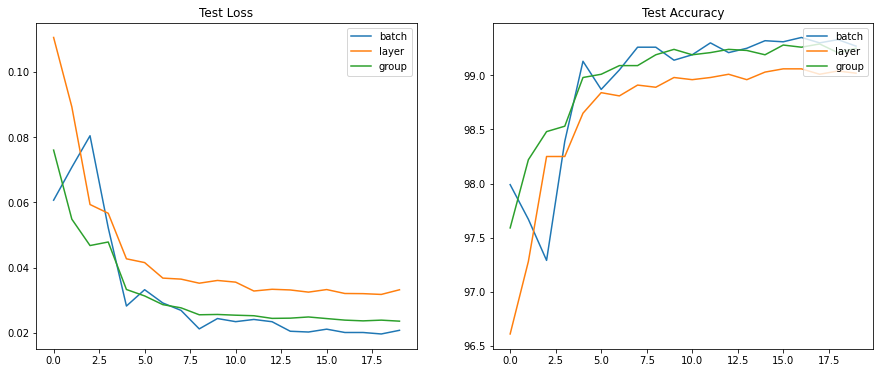

In [82]:
# function for plotting graphs
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1,2,figsize=(15,6))
axs[0].plot(b_test_losses, label = 'batch')
axs[0].plot(l_test_losses, label = 'layer')
axs[0].plot(g_test_losses, label = 'group')
axs[0].set_title("Test Loss")
axs[0].legend()
axs[0].legend(loc='upper right')

axs[1].plot(b_test_acc, label = 'batch')
axs[1].plot(l_test_acc, label = 'layer')
axs[1].plot(g_test_acc, label = 'group')
axs[1].set_title("Test Accuracy")
axs[1].legend()
axs[1].legend(loc='upper right')


# Define function that return data points for incorrect predictions

In [83]:
'''
function to return data points for plotting misses
It accepts trained model, device and test_loader as inputs
Outputs provided for all incorrect predictions, where length of each list = number of batches:
1. data_images - List of torch tensors of images, if no mispredictions in a given batch then empty tensor 
2. pred_labels - List of Predicted labels, if no mispredictions in a given batch then empty tensor 
3. target_labels - Ground truth or target labels, if no mispredictions in a given batch then empty tensor 
'''

def ntest(model, device, test_loader):
    model.eval()
    missed_images = []    #will contain list of batches, for a given batch will return list of indices not predicted correctly
                          #empty list will indicate no mis predictions
    pred_labels = []      #contains list of predicted labels by each batch
    data_images = []      #contains list of images by each batch for plotting
    target_labels = []    #contains list of target labels by batch
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            #missed_images.append(torch.where(torch.not_equal(pred.squeeze(),target).cpu()))
            misses = torch.where(torch.not_equal(pred.squeeze(),target))
            data_images.append(data[misses].cpu())
            target_labels.append(target[misses].cpu())
            pred_labels.append(pred[misses].cpu())
    return data_images, pred_labels, target_labels


# Define function to plot misclassifications

In [88]:
'''
function to return data points for plotting misses
It accepts the following
1. image_data as a list
2. targeted_labels as a list
3. predicted_labels as a list
4. classes - as a list
5. Number of images to be plotted

Required number of images are plotted as output with target and predicted labels
'''

def plot_misclassified(image_data, targeted_labels, predicted_labels, classes, no_images):
    
    no_images = min(no_images, len(predicted_labels))
    
    figure = plt.figure(figsize = (12,5))

    for index in range(1, no_images + 1):
        plt.subplot(2, 5, index)
        plt.imshow(image_data[index-1].numpy().squeeze())     
        plt.tick_params(left = False, right = False , labelleft = False ,
                    labelbottom = False, bottom = False)
        title = "Target:" + str(classes[targeted_labels[index-1]]) +"\nPredicted:" + str(classes[predicted_labels[index-1]])
        plt.title(title)

# Plot mispredictions for model with Batch Normalization & L1 Regularization

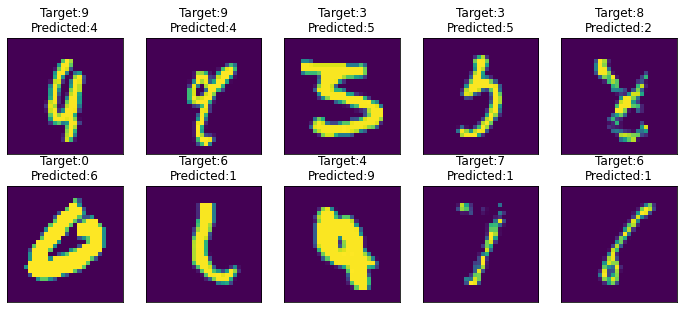

In [89]:
#batch_model = torch.load('batchmodel.pt')
data_images, pred_labels, target_labels = ntest(batch_model, device, test_loader)

#flatten the lists
flat_pred_labels = [x.item() for item in pred_labels for x in item ]
flat_target_labels = [x.item() for item in target_labels for x in item ]
flat_data_images = [x for item in data_images for x in item ]
#print(len(flat_data_images), len(flat_pred_labels), len(flat_target_labels))

# generate class labels
_,t = next(iter(test_loader))
classes = torch.unique(t, return_inverse=False, return_counts=False).tolist()
#print(classes)

plot_misclassified(flat_data_images, flat_target_labels, flat_pred_labels, classes, 10)

# Plot mispredictions for model with Layer Normalization

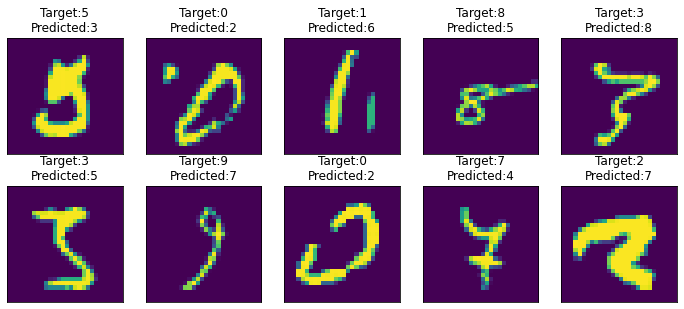

In [90]:
#batch_model = torch.load('batchmodel.pt')
data_images, pred_labels, target_labels = ntest(layer_model, device, test_loader)

#flatten the lists
flat_pred_labels = [x.item() for item in pred_labels for x in item ]
flat_target_labels = [x.item() for item in target_labels for x in item ]
flat_data_images = [x for item in data_images for x in item ]
#print(len(flat_data_images), len(flat_pred_labels), len(flat_target_labels))

# generate class labels
_,t = next(iter(test_loader))
classes = torch.unique(t, return_inverse=False, return_counts=False).tolist()
#print(classes)

plot_misclassified(flat_data_images, flat_target_labels, flat_pred_labels, classes, 10)

# Plot mispredictions for model with Group Normalization

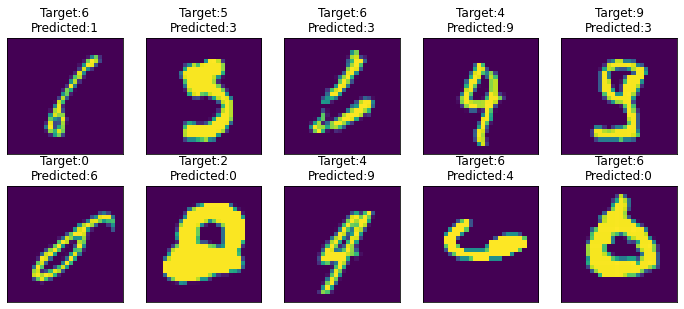

In [91]:
#batch_model = torch.load('batchmodel.pt')
data_images, pred_labels, target_labels = ntest(group_model, device, test_loader)

#flatten the lists
flat_pred_labels = [x.item() for item in pred_labels for x in item ]
flat_target_labels = [x.item() for item in target_labels for x in item ]
flat_data_images = [x for item in data_images for x in item ]
#print(len(flat_data_images), len(flat_pred_labels), len(flat_target_labels))

# generate class labels
_,t = next(iter(test_loader))
classes = torch.unique(t, return_inverse=False, return_counts=False).tolist()
#print(classes)

plot_misclassified(flat_data_images, flat_target_labels, flat_pred_labels, classes, 10)